In [31]:
from pandas import read_csv # For dataframes
from pandas import DataFrame # For dataframes
from numpy import ravel # For matrices
import matplotlib.pyplot as plt # For plotting data
import seaborn as sns # For plotting data
from sklearn.model_selection import train_test_split # For train/test splits
from sklearn.neighbors import KNeighborsClassifier # The k-nearest neighbor classifier
from sklearn.feature_selection import VarianceThreshold # Feature selector
from sklearn.pipeline import Pipeline # For setting up pipeline
# Various pre-processing steps
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler, PowerTransformer, MaxAbsScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV # For optimization

In [32]:
# dataframe df
df = read_csv(
    '/home/machio_b/Documents/Data_Sets/ecoli.data',
    sep = '\s+',
    header=None)
print(df.head())

            0     1     2     3    4     5     6     7   8
0   AAT_ECOLI  0.49  0.29  0.48  0.5  0.56  0.24  0.35  cp
1  ACEA_ECOLI  0.07  0.40  0.48  0.5  0.54  0.35  0.44  cp
2  ACEK_ECOLI  0.56  0.40  0.48  0.5  0.49  0.37  0.46  cp
3  ACKA_ECOLI  0.59  0.49  0.48  0.5  0.52  0.45  0.36  cp
4   ADI_ECOLI  0.23  0.32  0.48  0.5  0.55  0.25  0.35  cp


In [33]:
# The data matrix X
X = df.iloc[:,1:-1]
# The labels
y = (df.iloc[:,-1:])
 
# Encode the labels into unique integers
encoder = LabelEncoder()
y = encoder.fit_transform(ravel(y))
 
# Split the data into test and train
x_train, X_test, y_train, y_test = train_test_split(
    X,  
    y, 
    test_size=1/3,
    random_state=0)

In [34]:
knn = KNeighborsClassifier().fit(x_train, y_train)
print('Training set score: ' + str(knn.score(x_train,y_train)))
print('Test set score: ' + str(knn.score(X_test,y_test)))

Training set score: 0.9017857142857143
Test set score: 0.8482142857142857


In [35]:
pipe = Pipeline([
('scaler', StandardScaler()),
('selector', VarianceThreshold()),
('classifier', KNeighborsClassifier())
])

In [36]:
pipe.fit(x_train, y_train)

print('Training set score: ' + str(pipe.score(x_train,y_train)))
print('Test set score: ' + str(pipe.score(X_test,y_test)))

Training set score: 0.8794642857142857
Test set score: 0.8392857142857143


The pipeline from current observations has poor results that runnin on raw data
However, the beauty of classifiers is in tuning them

We can search for the best:
scalers, thresholds, classifiers

In [58]:
#tuning

parameters = {'scaler': [StandardScaler(), MinMaxScaler(), Normalizer(), MaxAbsScaler()],
                    'selector__threshold':[0,0.0001,0.01],
                    'classifier__n_neighbors':[1,3,5,7,10],
                    'classifier__p':[1,2,3],
                    'classifier__leaf_size':[1,5,10,15]
                }

these params are passed to gridsearchcv() obj and searches for param placement

In [59]:
grid = GridSearchCV(pipe, parameters, cv=3).fit(x_train, y_train)

/home/machio_b/miniconda3/envs/tf_venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


In [60]:
print('Training set score: ' + str(pipe.score(x_train,y_train)))
print('Test set score: ' + str(pipe.score(X_test,y_test)))

Training set score: 0.8794642857142857
Test set score: 0.8392857142857143


In [61]:
# Access the best set of parameters
best_params = grid.best_params_
print(best_params)
# Stores the optimum model in best_pipe
best_pipe = grid.best_estimator_
print(best_pipe)

{'classifier__leaf_size': 1, 'classifier__n_neighbors': 7, 'classifier__p': 1, 'scaler': Normalizer(), 'selector__threshold': 0}
Pipeline(steps=[('scaler', Normalizer()),
                ('selector', VarianceThreshold(threshold=0)),
                ('classifier',
                 KNeighborsClassifier(leaf_size=1, n_neighbors=7, p=1))])


In [62]:
result_df = DataFrame.from_dict(grid.cv_results_, orient='columns')
print(result_df.columns)

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_classifier__leaf_size', 'param_classifier__n_neighbors',
       'param_classifier__p', 'param_scaler', 'param_selector__threshold',
       'params', 'split0_test_score', 'split1_test_score', 'split2_test_score',
       'mean_test_score', 'std_test_score', 'rank_test_score'],
      dtype='object')


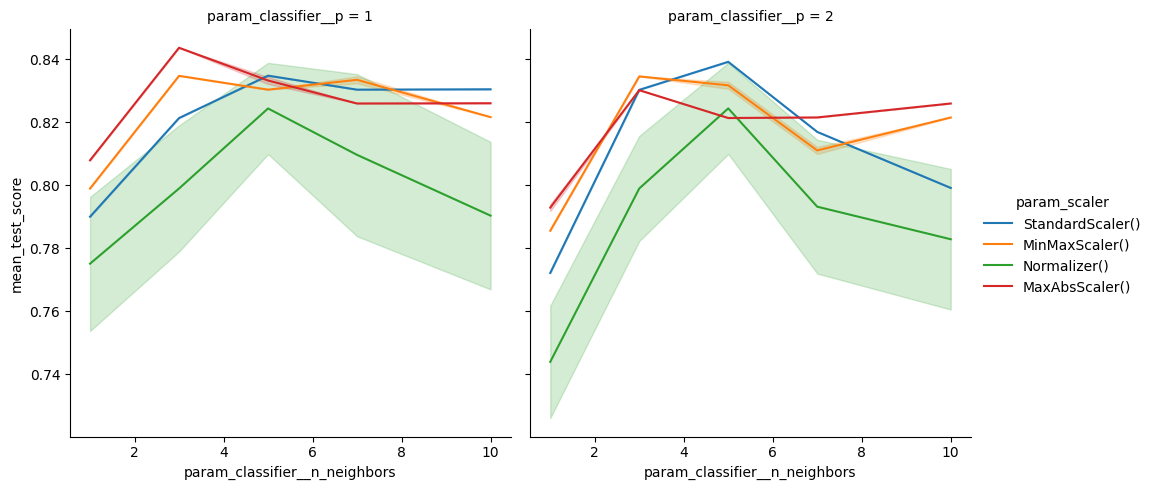

In [56]:
sns.relplot(data=result_df,
	kind='line',
	x='param_classifier__n_neighbors',
	y='mean_test_score',
	hue='param_scaler',
	col='param_classifier__p')
plt.show()